In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
#
# @Author: Mingyeong Yang (mmingyeong@kasi.re.kr)
# @Date: 2023-11-08
# @Filename: work.ipynb
# work for hw6 

import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import math

import pandas as pd

In [2]:
# Data Preparation
# Pantheon: SN Ia Pantheon data

file_lcparam_full_long = "./Pantheon/lcparam_full_long.txt"
file_sys_full_long = "./Pantheon/sys_full_long.txt"

open_lcparam_full_long = open(file_lcparam_full_long, "r")
open_sys_full_long = open(file_sys_full_long, "r")

df_lcparam_full_long = pd.read_csv(file_lcparam_full_long, sep = ' ')
df_sys_full_long = pd.DataFrame(open_sys_full_long)

In [3]:
# zcmb, mb 추출
df_lcparam_full_long = df_lcparam_full_long.iloc[:,[1,4]]
df_sys_full_long[0] = df_sys_full_long[0].str.replace(pat=r'\n', repl=r'', regex=True)

In [4]:
from IPython.display import display, HTML
#display(HTML(df_lcparam_full_long.to_html()))

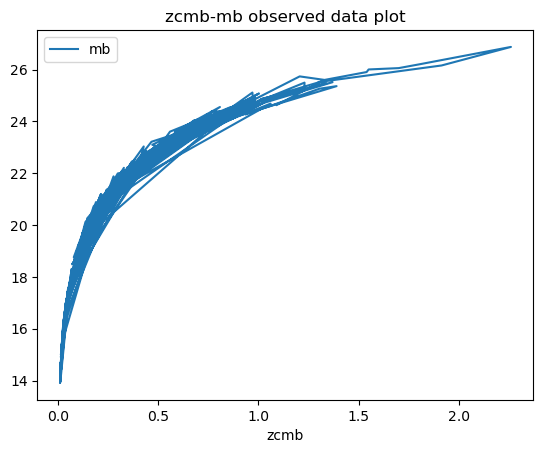

In [5]:
df_lcparam_full_long.plot(kind='line', x='zcmb', y='mb', title="zcmb-mb observed data plot")
plt.show()


In [6]:
import scipy.integrate as spi
import math

#The model you have to fit is the standard LCDM model and its mb is given by: 
#mb = 5log10(DL) + M
#where DL = (1+z)/H_0 \int_0^z dz c / h(z) 
#where h(z) = sqrt((1-Om0 + Om0(1+z)^3))
# The peak absolute magnitude
# MB = -19.3 + a*(s-1)-b*(c-0.1)
# s is the stretch of the supernova light curve, which is related to the duration of the event,
# c is the color of the supernova at maximum brightness,
# α and β are nuisance parameters determined through observations.

def DL_func(z, H0, Om0):
    def h_func(z):
        c = 299792 # km/sec
        h = np.sqrt((1-Om0 + Om0*(1+z)**3))
        return c/h
    qd_val, qd_err = spi.quad(h_func, 0, z)
    #print(type(qd)) # tuple
    #print(qd) # tuple # (132910.81525382065, 1.4756064731649215e-09)
    return ((1+z)/H0)*qd_val

def mb_model(z, H0, Om0, MB):
    # return value = mb
    results = []
    for z_val in z:
        DL_val = DL_func(z_val, H0, Om0)
        val = 5*math.log10(DL_val)+ MB
        results.append(val)

    return results


In [7]:
# χ² = Σ [(μ_obs - μ_expected)² / σ_obs²] 
# μ_obs 관측된 거리 계수: mb
# μ_expected ΛCDM 모델에 대해 계산된 거리 계수: Model 
# σ_obs 관측된 거리 계수의 불확실성: Sigma

def mean(data):
    # mean = sum / num
    sum = 0
    for i in data:
        sum = sum + i
    num = len(data)

    mean_val = sum / num
    
    return mean_val

def variance(data):
    # sum((val - self.mean)**2)/self.num
    sum = 0
    meanval= mean(data)
    num = len(data)
    for i in data:
        comp = (i - meanval)**2
        sum = sum + comp
    
    varianceval = sum / num
    return varianceval

def StandardDeviation(data):
    # variance**(1/2)
    val=variance(data)
    StandardDeviation_val = val**(1/2)
    return StandardDeviation_val

def chi_squared(y, model, sigma):
    sum = 0
    for i in range(len(y)):
        Chi_squared = (y[i]-model[i])**2/sigma**2
        sum = sum + Chi_squared

    return sum


In [8]:
mb = df_lcparam_full_long["mb"]
z = df_lcparam_full_long["zcmb"]

sigma = StandardDeviation(mb)
H0 = 70
#Om0 = 0.3
Om0_range = np.arange(0, 1, 0.01)
MB = 19.3

chis = []
for Om0 in Om0_range:
    chis_val = chi_squared(mb, mb_model(z, H0, Om0, MB), sigma)
    chis.append(chis_val)

In [9]:
print(min(chis))

26836.889330061655


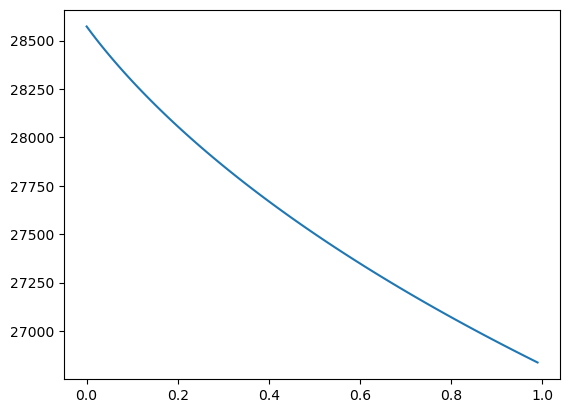

In [10]:
plt.figure()
plt.plot(Om0_range, chis)
plt.show()

In [11]:
def chi_squared_cov(y, model, cov):
    dm = []
    for i in range(len(y)):
        term1 = y[i]-model[i]
        dm.append(term1)
        
    dm_arr = np.array(dm)
    dm_transpose = dm_arr.T # transpose matrix of y
    # inverse of covariance matrix
    reg_param = 1e-3
    inv_cov = np.linalg.inv(cov + reg_param * np.eye(cov.shape[0]))
    #inv_cov = np.linalg.pinv(cov)
    term2 = np.dot(dm_transpose, inv_cov)
    chis_val = np.dot(term2, dm_arr)

    return chis_val

In [12]:
print(df_sys_full_long[0])

0                 1048
1          0.000179045
2          0.000146745
3            9.407e-05
4            9.915e-05
              ...     
1098300    0.001649435
1098301     0.00061895
1098302      0.0008832
1098303    0.001651565
1098304     0.00115222
Name: 0, Length: 1098305, dtype: object


In [13]:
cov_ex = np.array(df_sys_full_long[0][1:1049])
cov = []
n=1
while True:
    cov_comp = list(map(float, df_sys_full_long[0][n:n+1048]))
    cov.append(cov_comp)
    n=n+1048
    #print(n)
    if n >1098305:
        break

print(type(cov))
print(cov[-1])

cov.pop()
print(cov[-1])
cov_arr = np.array(cov)
print(type(cov_arr))

<class 'list'>
[]
[0.00014919, 0.000109355, 0.00018545, 0.00041744, 0.000254355, -9.935e-05, -0.00013966, -0.000145785, -2.155e-06, 0.0006539, 0.000174985, 0.000506955, 0.00024144, 3.7205e-05, -0.00019765, 0.000393965, 3.3795e-05, 0.000822505, 3.465e-06, 0.000251635, 0.000555645, 0.000658545, 0.000166325, 0.00020967, 0.0007777, 0.000169915, 0.000334005, -9.9825e-05, -0.000132215, 0.000194825, 0.00016901, 0.00018328, 4.448e-05, 0.000176945, 0.00084454, 0.00013096, -0.000132895, -2.4105e-05, 6.1325e-05, 0.000189445, 0.00028856, 0.000665315, -0.00015584, 0.000270825, 0.000133725, 8.0535e-05, 0.00093421, -8.7985e-05, 0.00016957, 0.00018038, 0.0006098, 0.000187295, 8e-07, 0.00069303, 0.00034104, 1.5845e-05, 0.00030577, -1.582e-05, 0.000411555, 0.000393935, 1.6395e-05, 8.057e-05, 0.00017802, -0.000113705, -0.000144265, 0.00018255, 0.000581385, -6.8825e-05, 0.000170365, -2.9215e-05, 0.00019085, 0.000209635, -0.00015111, -0.0001565, -0.00014114, 0.00043412, 0.00059318, -9.682e-05, 0.00048872, 

In [14]:
# 정규화: 거의 특이 행렬에 가까운 행렬을 처리할 때 수치적으로 불안정한 
# 문제가 발생할 수 있습니다. 이 문제를 해결하기 위해 역행렬을 구하기 전에 
# 행렬의 대각선에 작은 값을 추가하는 정규화 기술을 사용할 수 있습니다. 
# 특히, 공분산 행렬과 관련된 경우에 유용합니다.

reg_param = 1e-3
inv_cov = np.linalg.inv(cov_arr + reg_param * np.eye(cov_arr.shape[0]))
print(type(inv_cov))
print(inv_cov)

<class 'numpy.ndarray'>
[[ 9.85074959e+02 -1.16705814e+01 -1.34479571e+00 ... -7.91558858e-01
   2.27283573e+00  5.71579951e-01]
 [-1.16705814e+01  9.90131241e+02 -1.69315441e+00 ... -3.63382996e-01
   2.03673630e+00  6.55231330e-01]
 [-1.34479570e+00 -1.69315440e+00  9.88555999e+02 ... -1.49656743e-01
   1.40870035e+00  8.26064512e-01]
 ...
 [-7.91558854e-01 -3.63383002e-01 -1.49656756e-01 ...  9.77880471e+02
  -1.35569610e+01 -2.02395605e+01]
 [ 2.27283572e+00  2.03673629e+00  1.40870035e+00 ... -1.35569610e+01
   9.35153809e+02 -3.57763260e+01]
 [ 5.71579950e-01  6.55231323e-01  8.26064502e-01 ... -2.02395605e+01
  -3.57763260e+01  9.70637110e+02]]


In [20]:
H0 = 70
Om0 = 0.3
MB_arange = np.arange(4, 6, 0.1)

chis_cov = []
for MB in MB_arange:
    chis_val = chi_squared_cov(mb, mb_model(z, H0, Om0, MB), cov_arr)
    print(chis_val)
    chis_cov.append(chis_val)
min_chis = min(chis_cov)
indx = chis_cov.index(min_chis)
print(min_chis)
print(indx)
print(MB_arange[indx])

2793320.9154690234
2468845.9962792844
2164558.7565574716
1880459.1963035844
1616547.3155176225
1372823.1141995857
1149286.5923494755
945937.7499672906
762776.587053031
599803.1036066969
457017.29962828883
334419.17511780636
232008.73007524922
149785.96450061776
87750.87839391193
45903.471755131715
24243.744584277083
22771.696881348074
41487.32864634461
80390.63987926672
22771.696881348074
17
5.699999999999994


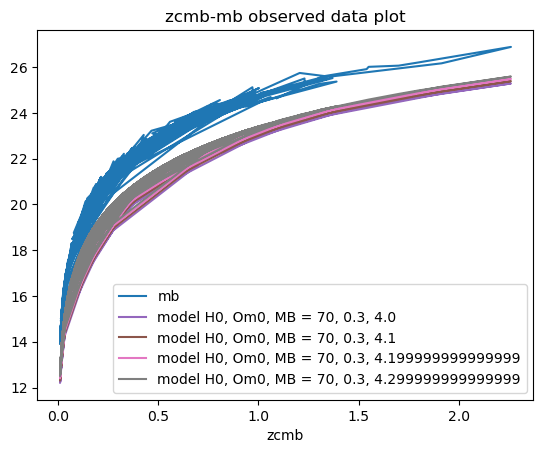

In [16]:
df_lcparam_full_long.plot(kind='line', x='zcmb', y='mb', title="zcmb-mb observed data plot")
plt.plot(df_lcparam_full_long["zcmb"], mb_model(z, H0, Om0, MB_arange[0]), color=f"C4", label=f"model H0, Om0, MB = {H0}, {Om0}, {MB_arange[0]}")
plt.plot(df_lcparam_full_long["zcmb"], mb_model(z, H0, Om0, MB_arange[1]), color=f"C5", label=f"model H0, Om0, MB = {H0}, {Om0}, {MB_arange[1]}")
plt.plot(df_lcparam_full_long["zcmb"], mb_model(z, H0, Om0, MB_arange[2]), color=f"C6", label=f"model H0, Om0, MB = {H0}, {Om0}, {MB_arange[2]}")
plt.plot(df_lcparam_full_long["zcmb"], mb_model(z, H0, Om0, MB_arange[3]), color=f"C7", label=f"model H0, Om0, MB = {H0}, {Om0}, {MB_arange[3]}")
plt.legend()
plt.show()

In [17]:
Om0 = 0.3
H0_range = np.arange(50, 100, 10)
MB = 5.7

chis_cov = []
for H0 in H0_range:
    chis_val = chi_squared_cov(mb, mb_model(z, H0, Om0, MB), cov_arr)
    chis_cov.append(chis_val)
min_chis = min(chis_cov)
indx = chis_cov.index(min_chis)
print(min_chis)
print(indx)
print(H0_range[indx])

22771.696881348544
2
70


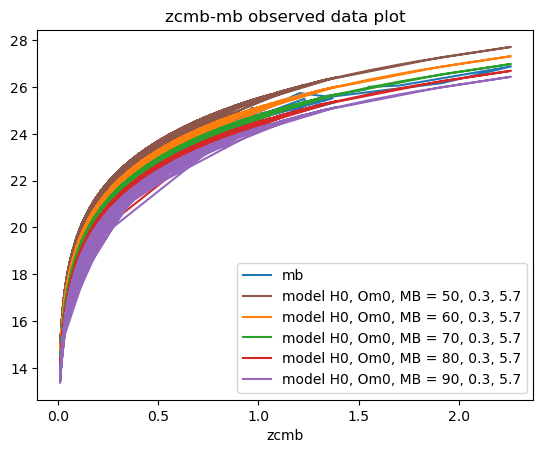

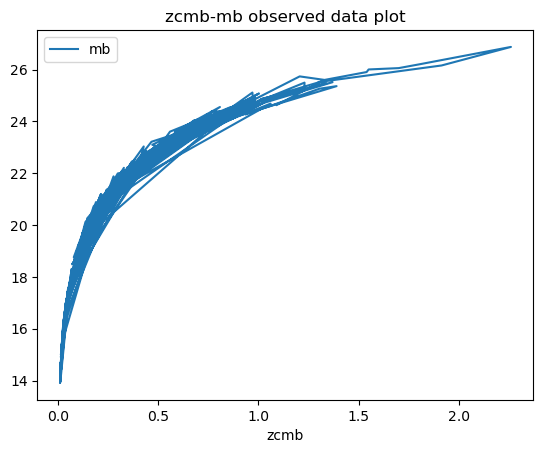

In [18]:
df_lcparam_full_long.plot(kind='line', x='zcmb', y='mb', title="zcmb-mb observed data plot")
plt.plot(df_lcparam_full_long["zcmb"], mb_model(z, H0_range[0], Om0, MB), color=f"C5", label=f"model H0, Om0, MB = {H0_range[0]}, {Om0}, {MB}")
plt.plot(df_lcparam_full_long["zcmb"], mb_model(z, H0_range[1], Om0, MB), color=f"C1", label=f"model H0, Om0, MB = {H0_range[1]}, {Om0}, {MB}")
plt.plot(df_lcparam_full_long["zcmb"], mb_model(z, H0_range[2], Om0, MB), color=f"C2", label=f"model H0, Om0, MB = {H0_range[2]}, {Om0}, {MB}")
plt.plot(df_lcparam_full_long["zcmb"], mb_model(z, H0_range[3], Om0, MB), color=f"C3", label=f"model H0, Om0, MB = {H0_range[3]}, {Om0}, {MB}")
plt.plot(df_lcparam_full_long["zcmb"], mb_model(z, H0_range[4], Om0, MB), color=f"C4", label=f"model H0, Om0, MB = {H0_range[4]}, {Om0}, {MB}")
plt.legend()
df_lcparam_full_long.plot(kind='line', x='zcmb', y='mb', title="zcmb-mb observed data plot")
plt.show()

In [19]:
Om0 = 0.3
H0_range = np.arange(50, 80, 0.1)
MB = 5.7

chis_cov = []
for H0 in H0_range:
    chis_val = chi_squared_cov(mb, mb_model(z, H0, Om0, MB), cov_arr)
    chis_cov.append(chis_val)
min_chis = min(chis_cov)
indx = chis_cov.index(min_chis)
print(min_chis)
print(indx)
print(H0_range[indx])

KeyboardInterrupt: 

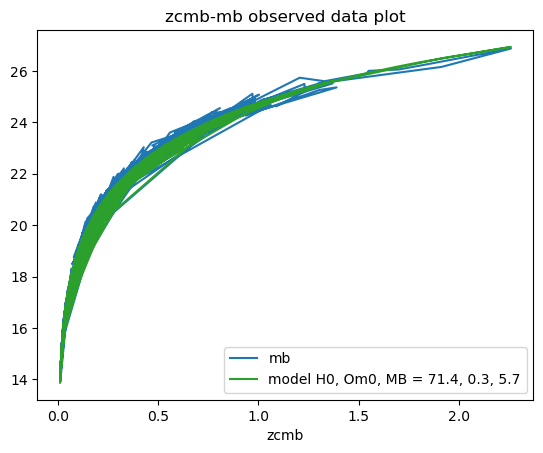

In [ ]:
Om0 = 0.3
H0 = 71.4
MB = 5.7
df_lcparam_full_long.plot(kind='line', x='zcmb', y='mb', title="zcmb-mb observed data plot")
plt.plot(df_lcparam_full_long["zcmb"], mb_model(z, H0, Om0, MB), color=f"C2", label=f"model H0, Om0, MB = {H0}, {Om0}, {MB}")
plt.legend()
plt.show()

In [ ]:
Om0_range = np.arange(0,0.5,0.1)
H0_range = np.arange(50,100,1)
MB = 6



In [ ]:
chis_cov = []
params = []
for Om0 in Om0_range:
    for H0 in H0_range:
        chis_val = chi_squared_cov(mb, mb_model(z, H0, Om0, MB), cov_arr)
        chis_cov.append(chis_val)
        params_val = [Om0, H0]
        print(params_val)
        params.append(params_val)

[0.0, 50]
[0.0, 51]
[0.0, 52]
[0.0, 53]
[0.0, 54]
[0.0, 55]
[0.0, 56]
[0.0, 57]
[0.0, 58]
[0.0, 59]
[0.0, 60]
[0.0, 61]
[0.0, 62]
[0.0, 63]
[0.0, 64]
[0.0, 65]
[0.0, 66]
[0.0, 67]
[0.0, 68]
[0.0, 69]
[0.0, 70]
[0.0, 71]
[0.0, 72]
[0.0, 73]
[0.0, 74]
[0.0, 75]
[0.0, 76]
[0.0, 77]
[0.0, 78]
[0.0, 79]
[0.0, 80]
[0.0, 81]
[0.0, 82]
[0.0, 83]
[0.0, 84]
[0.0, 85]
[0.0, 86]
[0.0, 87]
[0.0, 88]
[0.0, 89]
[0.0, 90]
[0.0, 91]
[0.0, 92]
[0.0, 93]
[0.0, 94]
[0.0, 95]
[0.0, 96]
[0.0, 97]
[0.0, 98]
[0.0, 99]
[0.1, 50]
[0.1, 51]
[0.1, 52]
[0.1, 53]
[0.1, 54]
[0.1, 55]
[0.1, 56]
[0.1, 57]
[0.1, 58]
[0.1, 59]
[0.1, 60]
[0.1, 61]
[0.1, 62]
[0.1, 63]
[0.1, 64]
[0.1, 65]
[0.1, 66]
[0.1, 67]
[0.1, 68]
[0.1, 69]
[0.1, 70]
[0.1, 71]
[0.1, 72]
[0.1, 73]
[0.1, 74]
[0.1, 75]
[0.1, 76]
[0.1, 77]
[0.1, 78]
[0.1, 79]
[0.1, 80]
[0.1, 81]
[0.1, 82]
[0.1, 83]
[0.1, 84]
[0.1, 85]
[0.1, 86]
[0.1, 87]
[0.1, 88]
[0.1, 89]
[0.1, 90]
[0.1, 91]
[0.1, 92]
[0.1, 93]
[0.1, 94]
[0.1, 95]
[0.1, 96]
[0.1, 97]
[0.1, 98]
[0.1, 99]


In [ ]:
min_chis = min(chis_cov)
indx = chis_cov.index(min_chis)
print(min_chis)
print(indx)
print("Om0, H0", params[indx])

20931.356860146876
182
Om0, H0 [0.30000000000000004, 82]


In [ ]:
H0 = 71.4
MB = 5.7
Om0_range = np.arange(0,0.5,0.01)
chis_cov = []
params = []
for Om0 in Om0_range:
    chis_val = chi_squared_cov(mb, mb_model(z, H0, Om0, MB), cov_arr)
    chis_cov.append(chis_val)
    params.append(Om0)
    
min_chis = min(chis_cov)
indx = chis_cov.index(min_chis)
print(min_chis)
print(indx)
print("Om0", params[indx])

20930.677781483653
30
Om0 0.3


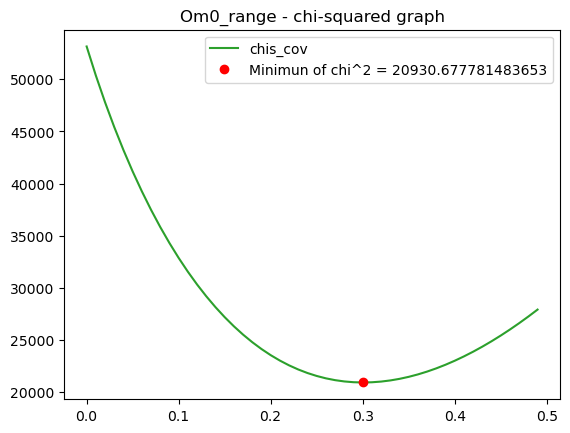

In [ ]:
plt.figure()
plt.plot(Om0_range, chis_cov, color=f"C2", label=f"chis_cov")
plt.plot(params[indx], min_chis, "ro", label=f"Minimun of chi^2 = {min_chis}")
plt.title("Om0_range - chi-squared graph")
plt.legend()
plt.show()

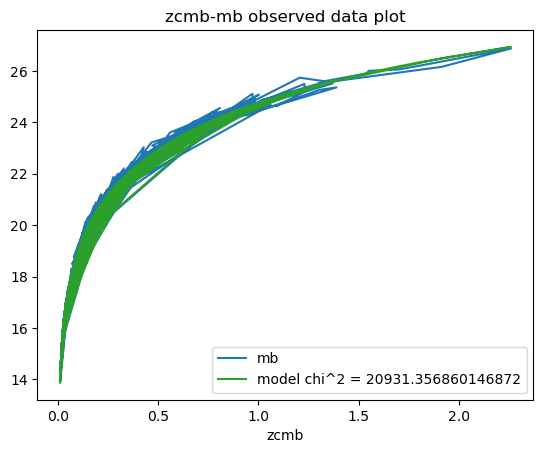

In [ ]:
Om0 = 0.3
H0 = 82
MB = 6
chis_min = chi_squared_cov(mb, mb_model(z, H0, Om0, MB), cov_arr)
df_lcparam_full_long.plot(kind='line', x='zcmb', y='mb', title="zcmb-mb observed data plot")
plt.plot(df_lcparam_full_long["zcmb"], mb_model(z, H0, Om0, MB), color=f"C2", label=f"model chi^2 = {chis_min}")
plt.legend()
plt.show()

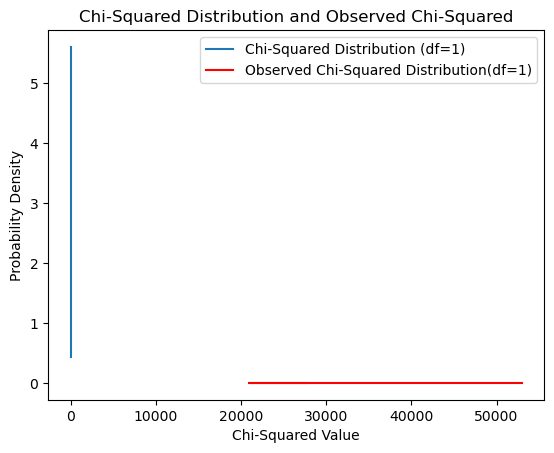

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.optimize import minimize

# Degrees of freedom (number of data points minus number of parameters)
degrees_of_freedom = 1

# Probability density function (PDF) of the chi-squared distribution
chi_squared_pdf = chi2.pdf(chis_cov, degrees_of_freedom)

# Generate chi-squared values for plotting the distribution
x = np.linspace(0, 0.5, 100)
y = chi2.pdf(x, degrees_of_freedom)

# Plot the chi-squared distribution
plt.plot(x, y, label=f'Chi-Squared Distribution (df={degrees_of_freedom})')
plt.plot(chis_cov, chi_squared_pdf, label=f'Observed Chi-Squared Distribution(df={degrees_of_freedom})', color="r")
#plt.axvline(chi_squared_pdf, color='red', linestyle='dashed', linewidth=2, label='Observed Chi-Squared')
plt.title('Chi-Squared Distribution and Observed Chi-Squared')
plt.xlabel('Chi-Squared Value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()